<a href="https://colab.research.google.com/github/paulosrl/NotebooksGoogleColab/blob/main/Rede_de_artistas_relacionados_Spotify_V1_0_Gephi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# API de importação de redes de artistas Spotify

## Adpatado do script original de @Kautenja
O autor [@Kautenja](https://gist.github.com/Kautenja) utiliza um wrapper Python para obter os dados utilizando usuário e senha válido do spotify.

> Notebook original em:  [notebook - @Kautenja](https://gist.github.com/Kautenja/71f139eee58099b77e91a0d775e42b47#file-visualizing-spotify-related-artists-with-gephi-ipynb) de @Kautenja no gist.


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# instalação da biblioteca do SPotify
%pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Acessar o portal de desenvolvedor do Spotify

Obter as credenciais de acesso ao Spotify, consulte documentação em: https://developer.spotify.com/

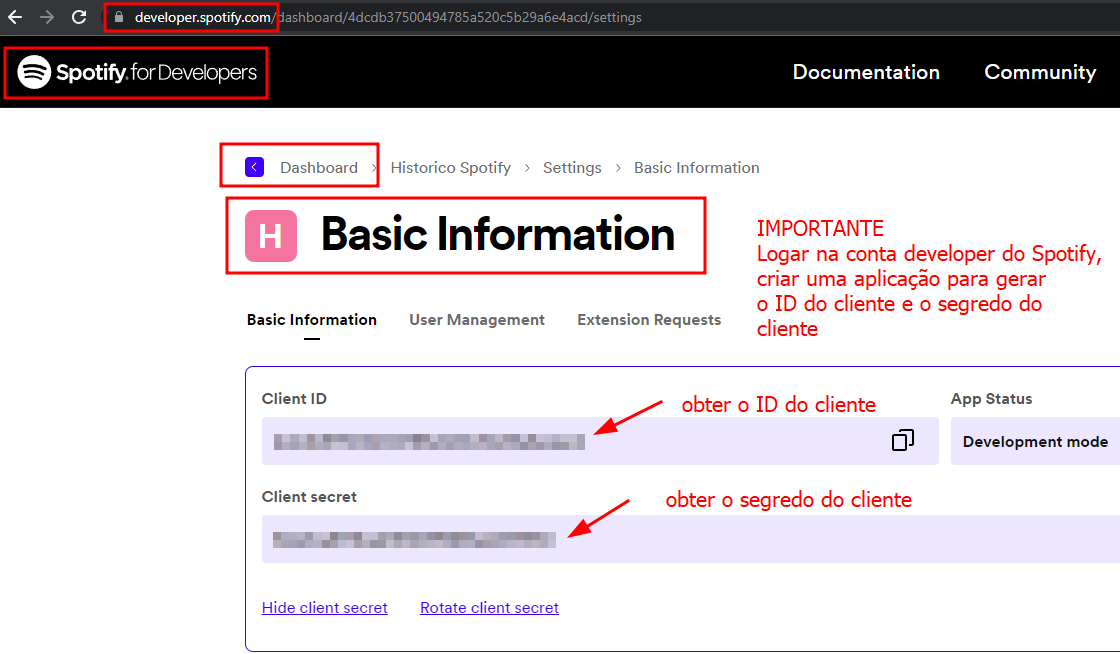

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Inserir aqui as credencias de acesso do Spotify
# cliente_id client_secret do seu usuário
client_id = 'seu id do spotify'
client_secret = 'segredo do spotify'

# conexão com o Spotify
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## Artista Raiz

Buscar o ID do artist no spotify

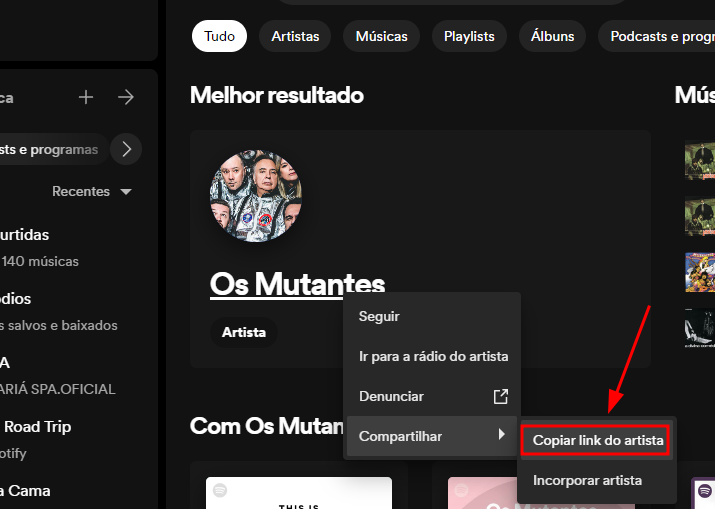


O resultado será um link:

Por exemplo:

https://open.spotify.com/artist/5C0gCCG8N5Dh5dZytIgzLX?si=505b9206f7294e4a

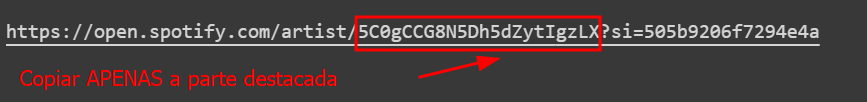

In [ ]:
# The Beatles  (artista selecionado)
artista = 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl2'

# OUTROS EXEMPLOS DE ARTISTAS
# Os mutantes
# seed_artist = 'spotify:artist:5C0gCCG8N5Dh5dZytIgzLX'
# Iron Maiden
#seed_artist = 'spotify:artist:6mdiAmATAx73kdxrNrnlao'
# Legiao Urbana
#seed_artist = 'spotify:artist:6tw6EpC9RgmSRZiZg0n22t'

# Building A Network

To build a network, I'll use a modified form of depth limited DFS to generate a dictionary of artists to a list of related artists.

In [ ]:
def related_network(artist_id, depth: int=3) -> dict:
    """
    Return a dictionary of artist names to lists of their related artists.

    Args:
        arist_id: the id of the artist to start the graph from
        depth: the depth into the related artist network

    Returns: a dictionary of strings (artist name) to lists (related artists)
    """
    graph = dict()
    _related_network(artist_id, depth, graph)
    return graph

def _related_network(artist_id, depth, graph):
    """
    Recursively collect related artists and store the results in the graph.

    Args:
        artist_id: artista
        depth: profundidade no grafo
        graph: dicionario onde serão inseridos os dados dos artistas relacionados
    """
    if depth == 0:
        return
    name = sp.artist(artist_id)['name']
    like_artist = sp.artist_related_artists(artist_id)
    graph[name] = [related['name'] for related in like_artist['artists']]
    [_related_network(related['id'], depth - 1, graph) for related in like_artist['artists']]

In [ ]:
# Verificando o caso base (primeiro artista)
related_network(artista, 1)

{'The Beatles': ['John Lennon',
  'George Harrison',
  'Paul McCartney',
  'The Beach Boys',
  'The Kinks',
  'Ringo Starr',
  'Bob Dylan',
  'The Hollies',
  'Simon & Garfunkel',
  'The Byrds',
  'The Rolling Stones',
  'Buddy Holly',
  'Wings',
  'Badfinger',
  'Chuck Berry',
  'Donovan',
  'Jimi Hendrix',
  'Roy Orbison',
  'Eric Clapton',
  'Elvis Presley']}

In [ ]:
# busca a partir do caso base, em 4 níveis de profundidade
# o parâmetro número=4 é o nível de profundidade da busca

artistasSemelhantes = related_network(artista, 3)

# Geração dos nós da Rede

In [ ]:
# função para gerar o nó
def nodes(graph: dict) -> pd.DataFrame:
    """
    Return a dataframe of nodes for the given graph.

    Args:
        graph: the graph to generate a unique table of nodes from

    Returns: a dataframe with nodes and unique ids
    """
    _nodes = []

    # iterate over all the artists in the list
    for artist, related_list in graph.items():
        _nodes.append(artist)
        [_nodes.append(related) for related in related_list]

    # keep only unique nodes
    _nodes = np.unique(_nodes)
    # make a dataframe to generate ids
    _nodes = pd.DataFrame(_nodes, columns=['label'])
    # use the index columns as the id
    _nodes['id'] = _nodes.index
    return _nodes

In [ ]:
network_nodes = nodes(artistasSemelhantes)
network_nodes.head()

,label,id
0,10cc,0
1,13th Floor Elevators,1
2,1910 Fruitgum Company,2
3,20/20,3
4,38 Special,4


# Geração das arestas da rede

In [ ]:
# função para gerar as arestas
def edges(graph: dict, nodes: pd.DataFrame) -> pd.DataFrame:
    """
    Return a dataframe of edges based on the graph and table of node ids.

    Args:
        graph: the graph to find edges in
        nodes: the table of nodes with unique node ids

    Returns: a table of targets to destinations by unique id
    """
    _edges = []

    for artist, related_list in graph.items():
        artist_node = nodes['id'][nodes['label'] == artist].values[0]
        for related in related_list:
            related_node = nodes['id'][nodes['label'] == related].values[0]
            _edges.append((artist_node, related_node))

    return pd.DataFrame(_edges, columns=['Source','Target'])

# Resumo origem e destino

In [ ]:
network_edges = edges(artistasSemelhantes, network_nodes)
network_edges.head()

,Source,Target
0,625,332
1,625,222
2,625,480
3,625,624
4,625,688


# Gravar no google drive o resultado

In [ ]:
# se desejar gravar no drive em rede
#from google.colab import drive
#drive.mount('/content/drive')

# Salvar no computador local as saídas

# Salvando os nós

In [ ]:
# gera arquivo de nós
from google.colab import files
network_nodes.to_csv('nodes.csv', index = False)
files.download('nodes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Salvando as arestas

In [ ]:
# gera arquivo de arestas (relacionamentos)
network_edges.to_csv('edges.csv', index = False)
files.download('edges.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>